<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>



# Basic spatial operations in  Geo Dataframes

We will review some important operations for geodataframes. As usual, let's do this: 

1. Create a repository named: **geodf_operations**.
2. Clone that repo to a local folder in your computer.
3. In that local folder in your computer, create a folder named **maps** and **data**.
4. Download the shapefile of "Brazil - Subnational Administrative Boundaries"(bra_adm_ibge_2020_SHP.zip) from [here](https://data.humdata.org/dataset/cod-ab-bra) and save it in the maps folder (you need to unzip the file).
5. Download a **CSV** file with information on the airports in Brazil from this [website](https://data.humdata.org/dataset/ourairports-bra), Save it in my **data** folder:
6. Commit and push.

Let's remember the contents of the world map from last session:

In [129]:
linkWorldMap="https://github.com/CienciaDeDatosEspacial/intro_geodataframe/raw/main/maps/worldMaps.gpkg"


import geopandas as gpd
from  fiona import listlayers
listlayers(linkWorldMap)

['countries', 'rivers', 'cities', 'indicators']

Let's open three layers

In [130]:
countries=gpd.read_file(linkWorldMap,layer='countries')
rivers=gpd.read_file(linkWorldMap,layer='rivers')
cities=gpd.read_file(linkWorldMap,layer='cities')
indicators=gpd.read_file(linkWorldMap,layer='indicators')

Now, let's see some important spatial operations:

1. [Subsetting](#0)
2. [Formatting Projection](#1)
    * [Projecting Geoseries](#11) 
    * [Projecting Naive Geodata](#12)
    * [Projecting long/lat](#13)
    
3. [Combining GeoDF rows](#2)
    * [Dissolving](#21) 
    * [Unary union](#22)
      
4. [Creating Spatial Points](#3)
    * [Creating a convex hull](#31)
5. [Checking Validity](#4)



## Subsetting

You can keep some elements by subsetting by *filtering*:

In [4]:
countries.head()

,COUNTRY,geometry
0,Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."


In [3]:
brazil=countries[countries.COUNTRY=='Brazil']

But you can also subset by *clipping*, as sometimes other data frames may not have the same fields for filtering:

In [5]:
citiesBrazil_clipped = gpd.clip(gdf=cities,
                          mask=brazil)
riversBrazil_clipped = gpd.clip(gdf=rivers,
                               mask=brazil)

Then, you can plot the clipped version:

<Axes: >

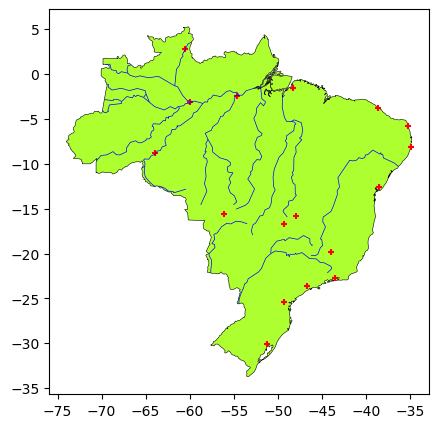

In [8]:
base = brazil.plot(facecolor="greenyellow", edgecolor='black', linewidth=0.4,figsize=(5,5))
citiesBrazil_clipped.plot(marker='+', color='red', markersize=15,
                    ax=base)
riversBrazil_clipped.plot(edgecolor='blue', linewidth=0.5,
                    ax=base)

You can also check what geometries you have in your GDF:

In [12]:
set(brazil.geom_type), set(citiesBrazil_clipped.geom_type), set(riversBrazil_clipped.geom_type)

({'MultiPolygon'}, {'Point'}, {'LineString', 'MultiLineString'})

Notice that the amount of elements (rows) is different, and that all those elements do not belong to the exact geometry type

### Exercise 1
<div class="alert-success">

1. Follow the same steps in this last section to plot three maps of one country. Do not use Brazil.
2. Plot your three layers.
    
</div>

## Map Projection

The CRS is a very important property of the maps. They affect three some aspects:

* shape
* area
* scale
* direction

Most maps come with a default CRS: 4326. Pay attention:

In [13]:
brazil.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
# check units of measurement
brazil.crs.axis_info

[Axis(name=Geodetic latitude, abbrev=Lat, direction=north, unit_auth_code=EPSG, unit_code=9122, unit_name=degree),
 Axis(name=Geodetic longitude, abbrev=Lon, direction=east, unit_auth_code=EPSG, unit_code=9122, unit_name=degree)]

In [15]:
# is this CRS projected?
brazil.crs.is_projected

False

Polygons have a centroid. When we try getting a centroid from an **unprojected** polygon, you get:

In [16]:
# centroid
brazil.centroid

/var/folders/2n/bkfhfqq16r78g3hf7pdj56y40000gn/T/ipykernel_88785/515368123.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brazil.centroid


29    POINT (-53.09009 -10.77302)
dtype: geometry

### Reprojecting

A projected CRS will have units in meters or feet (or similar). You can request a crs per country [here](https://epsg.io/?q=brazil+kind%3APROJCRS):

In [17]:
# recommended for Brazil (meters)
brazil.to_crs(5641).crs.axis_info

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre),
 Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]

In [18]:
# now this works with no warning
brazil.to_crs(5641).centroid

29    POINT (3884486.179 8756856.093)
dtype: geometry

<Axes: >

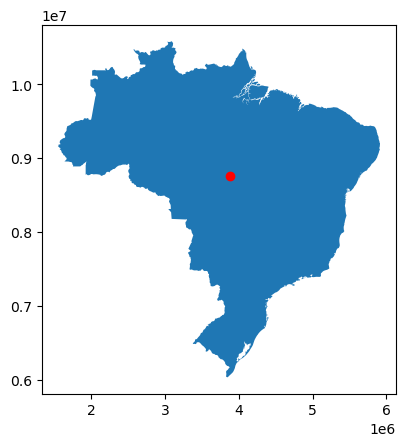

In [19]:
# replotting:

base5641=brazil.to_crs(5641).plot()
brazil.to_crs(5641).centroid.plot(color='red',ax=base5641)

Let's keep the projected version for all our maps:

In [20]:
brazil_5641=brazil.to_crs(5641)
cities_brazil_5641=citiesBrazil_clipped.to_crs(brazil_5641.crs)
rivers_brazil_5641=riversBrazil_clipped.to_crs(brazil_5641.crs)

In [21]:
## saving


import os

brazil_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='country', driver="GPKG")
cities_brazil_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='cities', driver="GPKG")
rivers_brazil_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='rivers', driver="GPKG")
brazil_5641.centroid.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='centroid', driver="GPKG")

### Exercise 2
<div class="alert-success">

1. Reproject your country's map layers.
2. Plot the reprojected layers
3. Save the reprojected layers
    
</div>

<a class="anchor" id="3"></a>

## Creating Spatial data

You will get Lines and Polygons as maps for sure, but that may not be the case with points. Let's open the **CSV** with information on the airports in Brazil:

In [22]:
import pandas as pd
infoairports=pd.read_csv(os.path.join("data","br-airports.csv"))

# some rows

infoairports.iloc[[0,1,2,3,-4,-3,-2,-1],:] #head and tail


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,...,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated
0,#meta +id,#meta +code,#loc +airport +type,#loc +airport +name,#geo +lat,#geo +lon,#geo +elevation +ft,#region +continent +code,#country +name,#country +code +iso2,...,#loc +municipality +name,#status +scheduled,#loc +airport +code +gps,#loc +airport +code +iata,#loc +airport +code +local,#meta +url +airport,#meta +url +wikipedia,#meta +keywords,#meta +score,#date +updated
1,5910,SBGR,large_airport,Guarulhos - Governador André Franco Montoro In...,-23.431944,-46.467778,2461,SA,Brazil,BR,...,São Paulo,1,SBGR,GRU,SP0002,http://www.aeroportoguarulhos.net/,https://en.wikipedia.org/wiki/S%C3%A3o_Paulo-G...,Cumbica,1016675,2021-10-28T15:52:55+00:00
2,5906,SBGL,large_airport,Rio Galeão – Tom Jobim International Airport,-22.809999,-43.250557,28,SA,Brazil,BR,...,Rio De Janeiro,1,SBGL,GIG,RJ0001,NaN,https://en.wikipedia.org/wiki/Rio_de_Janeiro-G...,Galeão - Antônio Carlos Jobim International Ai...,51475,2021-10-14T18:09:35+00:00
3,5974,SBSP,medium_airport,Congonhas Airport,-23.627657,-46.654601,2631,SA,Brazil,BR,...,São Paulo,1,SBSP,CGH,SP0001,http://www.infraero.gov.br/usa/aero_prev_home....,https://en.wikipedia.org/wiki/Congonhas-S%C3%A...,http://www.infraero.gov.br/usa/aero_prev_home....,750,2022-05-03T20:10:35+00:00
6668,309669,SSVR,closed,Volta Redonda Airport,-22.4978,-44.085,1245,SA,Brazil,BR,...,Volta Redonda,0,NaN,NaN,NaN,NaN,NaN,"SSVR, SSVR, QVR",0,2013-09-28T14:52:12+00:00
6669,505308,BR-1760,heliport,Unimed Volta Redonda Helipad,-22.533988,-44.076918,1385,SA,Brazil,BR,...,Volta Redonda,0,SSKV,NaN,RJ0147,NaN,NaN,NaN,0,2022-12-06T21:28:25+00:00
6670,341727,BR-1429,heliport,Santa Helena Heliport,-23.59851,-47.441196,2254,SA,Brazil,BR,...,Votorantim,0,SWHE,NaN,SP0807,NaN,NaN,NaN,0,2021-03-07T10:30:07+00:00
6671,343017,BR-1493,heliport,Bandeiras Centro Empresarial Heliport,-23.536615,-47.449475,1827,SA,Brazil,BR,...,Votorantim,0,SWST,NaN,SP1306,NaN,NaN,NaN,0,2021-04-14T20:12:01+00:00


This needs some cleaning:

In [23]:
# bye first row
infoairports.drop(index=0,inplace=True)
infoairports.reset_index(drop=True, inplace=True)
infoairports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,...,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated
0,5910,SBGR,large_airport,Guarulhos - Governador André Franco Montoro In...,-23.431944,-46.467778,2461,SA,Brazil,BR,...,São Paulo,1,SBGR,GRU,SP0002,http://www.aeroportoguarulhos.net/,https://en.wikipedia.org/wiki/S%C3%A3o_Paulo-G...,Cumbica,1016675,2021-10-28T15:52:55+00:00
1,5906,SBGL,large_airport,Rio Galeão – Tom Jobim International Airport,-22.809999,-43.250557,28,SA,Brazil,BR,...,Rio De Janeiro,1,SBGL,GIG,RJ0001,NaN,https://en.wikipedia.org/wiki/Rio_de_Janeiro-G...,Galeão - Antônio Carlos Jobim International Ai...,51475,2021-10-14T18:09:35+00:00
2,5974,SBSP,medium_airport,Congonhas Airport,-23.627657,-46.654601,2631,SA,Brazil,BR,...,São Paulo,1,SBSP,CGH,SP0001,http://www.infraero.gov.br/usa/aero_prev_home....,https://en.wikipedia.org/wiki/Congonhas-S%C3%A...,http://www.infraero.gov.br/usa/aero_prev_home....,750,2022-05-03T20:10:35+00:00
3,5967,SBRJ,medium_airport,Santos Dumont Airport,-22.9105,-43.163101,11,SA,Brazil,BR,...,Rio de Janeiro,1,SBRJ,SDU,RJ0002,https://www4.infraero.gov.br/aeroportos/aeropo...,https://en.wikipedia.org/wiki/Santos_Dumont_Ai...,RIO,750,2022-03-28T23:27:00+00:00
4,5872,SBBR,large_airport,Presidente Juscelino Kubitschek International ...,-15.869167,-47.920834,3497,SA,Brazil,BR,...,Brasília,1,SBBR,BSB,DF0001,http://www.infraero.gov.br/usa/aero_prev_home....,https://en.wikipedia.org/wiki/Bras%C3%ADlia_In...,NaN,51275,2020-08-24T11:15:12+00:00


In [24]:
# keep the  columns needed

infoairports.columns


Index(['id', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg',
       'elevation_ft', 'continent', 'country_name', 'iso_country',
       'region_name', 'iso_region', 'local_region', 'municipality',
       'scheduled_service', 'gps_code', 'iata_code', 'local_code', 'home_link',
       'wikipedia_link', 'keywords', 'score', 'last_updated'],
      dtype='object')

In [25]:
keep=['name','type','latitude_deg', 'longitude_deg','elevation_ft','region_name','municipality']
infoairports=infoairports.loc[:,keep]

infoairports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6671 entries, 0 to 6670
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           6671 non-null   object
 1   type           6671 non-null   object
 2   latitude_deg   6671 non-null   object
 3   longitude_deg  6671 non-null   object
 4   elevation_ft   6500 non-null   object
 5   region_name    6671 non-null   object
 6   municipality   6647 non-null   object
dtypes: object(7)
memory usage: 364.9+ KB


Some formatting:

In [26]:
numericCols=['latitude_deg', 'longitude_deg','elevation_ft']
infoairports[numericCols]=infoairports.loc[:,numericCols].apply(lambda x:pd.to_numeric(x))

In [27]:
# now
infoairports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6671 entries, 0 to 6670
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6671 non-null   object 
 1   type           6671 non-null   object 
 2   latitude_deg   6671 non-null   float64
 3   longitude_deg  6671 non-null   float64
 4   elevation_ft   6500 non-null   float64
 5   region_name    6671 non-null   object 
 6   municipality   6647 non-null   object 
dtypes: float64(3), object(4)
memory usage: 364.9+ KB


<Axes: xlabel='longitude_deg', ylabel='latitude_deg'>

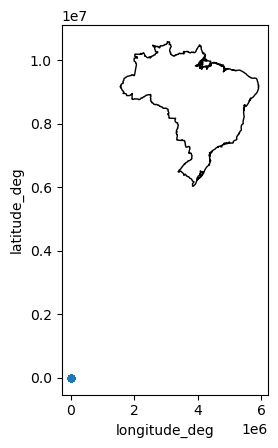

In [28]:
# let's plot

base = brazil_5641.plot(color='white', edgecolor='black') #unprojected

infoairports.plot.scatter(x = 'longitude_deg', y = 'latitude_deg',ax=base)

Why is it wrong?

<Axes: >

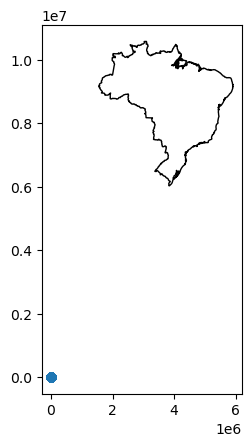

In [29]:
airports=gpd.GeoDataFrame(data=infoairports.copy(),
                 geometry=gpd.points_from_xy(infoairports.longitude_deg,
                                             infoairports.latitude_deg),
                 crs=brazil.crs.to_epsg())# the coordinates were in degrees - unprojected

# let's plot

base = brazil_5641.plot(color='white', edgecolor='black')
airports.plot(ax=base)

In [30]:
#remember:
type(airports), type(infoairports)

(geopandas.geodataframe.GeoDataFrame, pandas.core.frame.DataFrame)

Let's re project!

<Axes: >

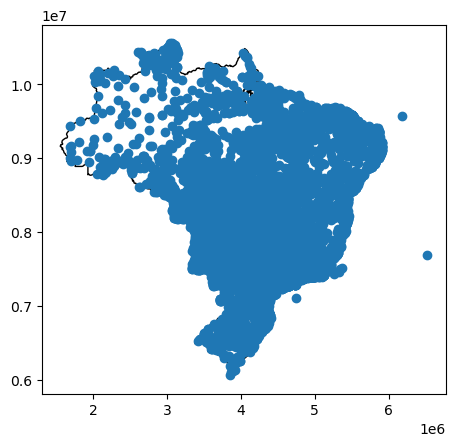

In [31]:
airports_5641=airports.to_crs(5641)

## then

base = brazil_5641.plot(color='white', edgecolor='black')
airports_5641.plot(ax=base)

Remember you have type of airports:

In [32]:
airports_5641['type'].value_counts() # this will not work: airports.type.value_counts()

type
small_airport     4587
heliport          1699
closed             251
medium_airport     124
large_airport        8
seaplane_base        2
Name: count, dtype: int64

We may use that in the future. For now, just rename the **type** column to a different one.

In [33]:
airports_5641.rename(columns={'type':'kind'},inplace=True)

## adding the airports to GPKG
airports_5641.to_file(os.path.join("maps","brazilMaps_5641.gpkg"), layer='airports', driver="GPKG")

### Exercise 3
<div class="alert-success">

1. Find the airports for your country [here](https://ourairports.com/data/). The data is in a CSV file.
2. Create projected layer of airports.
3. Plot all the layers and airports on top.
    
</div>

<a class="anchor" id="11"></a>

## Formating Geoseries projections



You know **brazil_5641** is a multipolygon:

In [160]:
brazil_5641

,COUNTRY,geometry
29,Brazil,"MULTIPOLYGON (((1926257.542 8894978.397, 19262..."


Sometime, you just need the border (lines):

In [161]:
brazil_5641.boundary

29    MULTILINESTRING ((1926257.542 8894978.397, 192...
dtype: geometry

<Axes: >

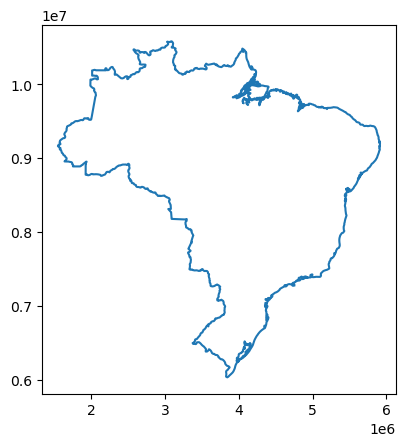

In [162]:
# This is just the borderline
brazil_5641.boundary.plot()

Always check the data type:

In [163]:
# does 'boundary' return a GDF?
type(brazil_5641.boundary)

geopandas.geoseries.GeoSeries

Some operations in geopandas require GDF or GS. If you need a GDF instead of a GS:

In [165]:
# converting into GDF
brazil_5641.boundary.to_frame()

,0
29,"MULTILINESTRING ((1926257.542 8894978.397, 192..."


Notice you get a very simple GDF, and you may want to add some information:

In [166]:
# conversion
brazil_border=brazil_5641.boundary.to_frame() 

# new column (optional)
brazil_border['name']='Brazil' 

# renaming the geometry column
brazil_border.rename(columns={0:'geometry'},inplace=True) 

#setting the geometry (the name is not enough)
brazil_border = brazil_border.set_geometry("geometry")

# verifying:
brazil_border.crs

<Projected CRS: EPSG:5641>
Name: SIRGAS 2000 / Brazil Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Brazil - offshore - equatorial margin.
- bounds: (-51.64, -5.74, -32.43, 7.04)
Coordinate Operation:
- name: Petrobras Mercator
- method: Mercator (variant B)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

You can add this GDF as a layer.

### Exercise 4

<div class="alert-success"> 
    
1. Check if your country is a polygon or multipolygon.
    
2. Recover just the boundaries of that country.
    
3. Turn the boundary into a GDF.
</div>

<a class="anchor" id="12"></a>

## Lacking CRS information

Reprojecting seems a simple process, but you might find some interesting cases. Let's read the maps on _states_ and _municipalities_:

In [41]:
brazil_states=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm1_ibge_2020.shp"))
brazil_municipalities=gpd.read_file(os.path.join("maps","bra_adm_ibge_2020_shp","bra_admbnda_adm2_ibge_2020.shp"))

Notice this:

In [42]:
brazil_states.crs, brazil_municipalities.crs

(None, None)

They do not have crs information, however they can be plotted:

<Axes: >

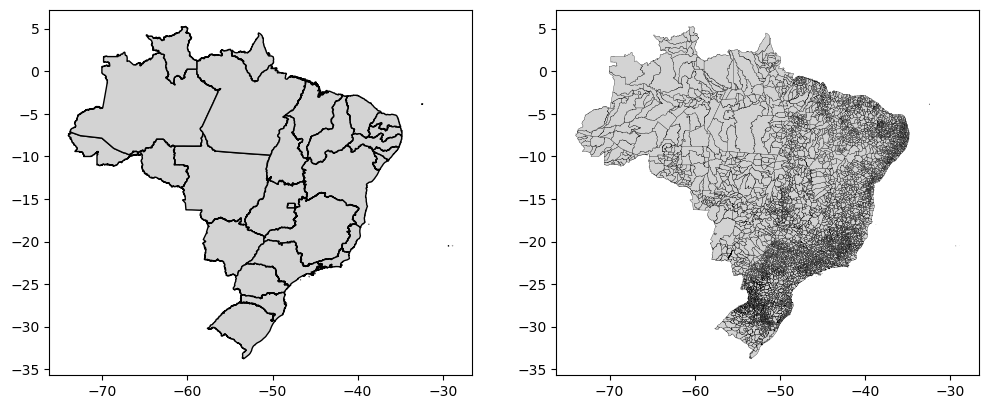

In [43]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(12,12))

brazil_states.plot(ax=ax1, facecolor='lightgrey', edgecolor='black')
brazil_municipalities.plot(ax=ax2, facecolor='lightgrey', edgecolor='black',linewidth=0.2)


Since we are using the crs 5641 for Brazil, the initial strategy could be to set the CRS with the right projection :

In [ ]:
# brazil_states.to_crs(5641)

Python says _"Please set a crs on the object first"_. This would mean to know the actual projection, of the geometry:

In [44]:
brazil_states.geometry.head()

0    MULTIPOLYGON (((-68.87747 -11.01987, -68.88027...
1    POLYGON ((-35.46317 -8.82467, -35.46457 -8.828...
2    MULTIPOLYGON (((-50.46147 2.11133, -50.45627 2...
3    MULTIPOLYGON (((-58.49367 -0.84197, -58.48917 ...
4    MULTIPOLYGON (((-38.70687 -17.96447, -38.70867...
Name: geometry, dtype: geometry

From the plots above and the previous rows, we conclude the maps are unprojected map; then:

In [45]:
brazil_states.crs = "EPSG:4326"
brazil_municipalities.crs = "EPSG:4326"

Now, we can reproject:

In [46]:
brazil_states=brazil_states.to_crs(5641)
brazil_municipalities=brazil_municipalities.to_crs(5641)

### Exercise 5

<div class="alert-success">

1. Look for sub administrative divisions of your country
2. Check all the CRSs of those divisions
3. If you find one CRS is missing, fill the CRS with the right projection.
</div>

<a class="anchor" id="2"></a>

## Combining GeoDF rows

Let me divide Brazil municipalities into a higher administrative level:

<Axes: >

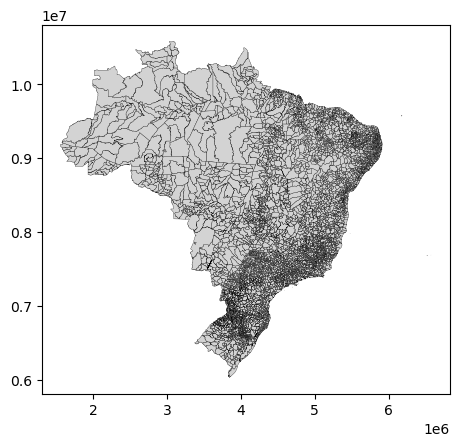

In [83]:
brazil_municipalities.plot(facecolor='lightgrey', edgecolor='black',linewidth=0.2)

In [79]:
#see
brazil_municipalities.head()

,ADM0_EN,ADM0_PT,ADM0_PCODE,ADM1_PT,ADM1_PCODE,ADM2_PT,ADM2_PCODE,ET_ID,geometry
0,Brazil,Brasil,BR,Rondônia,BR11,Alta Floresta D'Oeste,BR1100015,0,"POLYGON ((2880702.575 8678970.180, 2881137.154..."
1,Brazil,Brasil,BR,Rondônia,BR11,Ariquemes,BR1100023,1,"POLYGON ((2839173.154 8911097.984, 2838718.204..."
2,Brazil,Brasil,BR,Rondônia,BR11,Cabixi,BR1100031,2,"POLYGON ((3067184.343 8504324.153, 3067191.133..."
3,Brazil,Brasil,BR,Rondônia,BR11,Cacoal,BR1100049,3,"POLYGON ((2997393.730 8777661.276, 2997393.730..."
4,Brazil,Brasil,BR,Rondônia,BR11,Cerejeiras,BR1100056,4,"POLYGON ((2974496.868 8540812.592, 2974897.495..."


In [80]:
# higher level
brazil_municipalities.ADM1_PT.value_counts()

ADM1_PT
Minas Gerais           853
São Paulo              645
Rio Grande do Sul      499
Bahia                  417
Paraná                 399
Santa Catarina         295
Goiás                  246
Piauí                  224
Paraíba                223
Maranhão               217
Pernambuco             185
Ceará                  184
Rio Grande do Norte    167
Pará                   144
Mato Grosso            141
Tocantins              139
Alagoas                102
Rio de Janeiro          92
Mato Grosso do Sul      79
Espírito Santo          78
Sergipe                 75
Amazonas                62
Rondônia                52
Acre                    22
Amapá                   16
Roraima                 15
Distrito Federal         1
Name: count, dtype: int64

Then, this is Minas Gerais:

<Axes: >

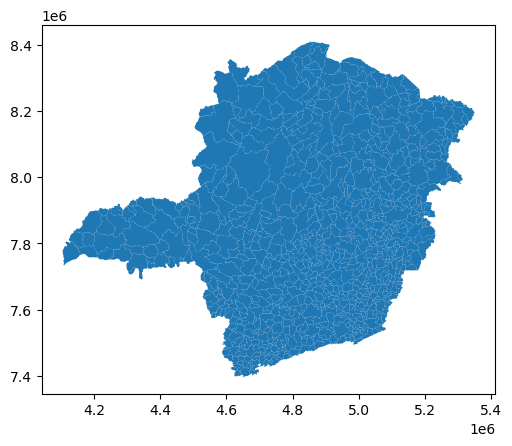

In [84]:
brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].plot()

In [81]:
brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais']

,ADM0_EN,ADM0_PT,ADM0_PCODE,ADM1_PT,ADM1_PCODE,ADM2_PT,ADM2_PCODE,ET_ID,geometry
2244,Brazil,Brasil,BR,Minas Gerais,BR31,Abadia dos Dourados,BR3100104,2244,"POLYGON ((4507276.097 7957426.902, 4507534.129..."
2245,Brazil,Brasil,BR,Minas Gerais,BR31,Abaeté,BR3100203,2245,"POLYGON ((4762767.595 7873308.749, 4763256.496..."
2246,Brazil,Brasil,BR,Minas Gerais,BR31,Abre Campo,BR3100302,2246,"POLYGON ((5076560.534 7726068.675, 5076241.390..."
2247,Brazil,Brasil,BR,Minas Gerais,BR31,Acaiaca,BR3100401,2247,"POLYGON ((4997283.884 7694563.581, 4997338.206..."
2248,Brazil,Brasil,BR,Minas Gerais,BR31,Açucena,BR3100500,2248,"MULTIPOLYGON (((5071379.541 7833933.162, 50711..."
...,...,...,...,...,...,...,...,...,...
3092,Brazil,Brasil,BR,Minas Gerais,BR31,Virginópolis,BR3171808,3092,"POLYGON ((5051742.019 7892410.561, 5051198.796..."
3093,Brazil,Brasil,BR,Minas Gerais,BR31,Virgolândia,BR3171907,3093,"POLYGON ((5088599.720 7929028.973, 5088165.141..."
3094,Brazil,Brasil,BR,Minas Gerais,BR31,Visconde do Rio Branco,BR3172004,3094,"POLYGON ((5026699.425 7629022.618, 5027188.326..."
3095,Brazil,Brasil,BR,Minas Gerais,BR31,Volta Grande,BR3172103,3095,"POLYGON ((5049087.015 7543986.840, 5049406.159..."


### Unary UNION

We can combine all these polygons into one:

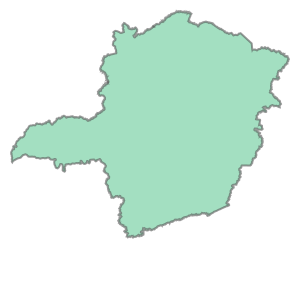

In [85]:
brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].unary_union

Let's save that result:

In [87]:
MinasGerais_union=brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].unary_union

In [88]:
# what do we have?
type(MinasGerais_union)

shapely.geometry.multipolygon.MultiPolygon

You can turn that shapely object into a GeoDF like this:

In [95]:
gpd.GeoDataFrame(index=[0],data={'ADM':'Minas Gerais'},
                 crs=brazil_municipalities.crs,
                 geometry=[MinasGerais_union])

,ADM,geometry
0,Minas Gerais,"MULTIPOLYGON (((4613768.235 7444013.818, 46132..."


<a class="anchor" id="21"></a>

### Dissolve

#### a. Dissolve as Union
Using  **dissolve** is an alternative to _UNION_:

<Axes: >

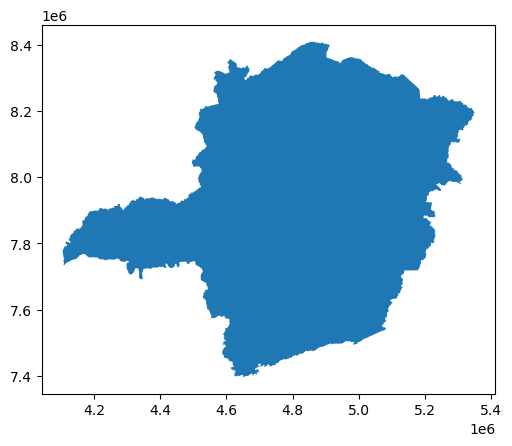

In [112]:
brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].dissolve().plot()

Let me save the result, ans see the type :

In [114]:
MinasGerais_dissolve=brazil_municipalities[brazil_municipalities.ADM1_PT=='Minas Gerais'].dissolve()

# we got?
type(MinasGerais_dissolve)

geopandas.geodataframe.GeoDataFrame

You got a GEOdf this time:

In [117]:
## see
MinasGerais_dissolve

,geometry,ADM0_EN,ADM0_PT,ADM0_PCODE,ADM1_PT,ADM1_PCODE,ADM2_PT,ADM2_PCODE,ET_ID
0,"MULTIPOLYGON (((4613768.235 7444013.818, 46132...",Brazil,Brasil,BR,Minas Gerais,BR31,Abadia dos Dourados,BR3100104,2244


In [119]:
# keeping what is relevant
MinasGerais_dissolve.drop(columns=['ADM2_PT','ADM2_PCODE','ET_ID'],inplace=True)

# then
MinasGerais_dissolve

,geometry,ADM0_EN,ADM0_PT,ADM0_PCODE,ADM1_PT,ADM1_PCODE
0,"MULTIPOLYGON (((4613768.235 7444013.818, 46132...",Brazil,Brasil,BR,Minas Gerais,BR31


#### b. Dissolve for groups

Using _dissolve()_ with no arguments returns the union of the polygons, BUT also you get a GEOdf.
However, if you have a column that represents a grouping (as we do), you can dissolve by a that column:

<Axes: >

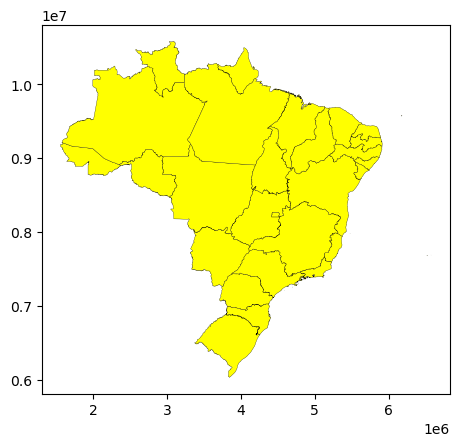

In [120]:
# dissolving
brazil_municipalities.dissolve(by='ADM1_PT').plot(facecolor='yellow', edgecolor='black',linewidth=0.2)

Again, let me save this result:

In [121]:
Brazil_adm1_diss=brazil_municipalities.dissolve(by='ADM1_PT')

We know we have a GeoDF; let's see contents:

In [122]:
Brazil_adm1_diss

,geometry,ADM0_EN,ADM0_PT,ADM0_PCODE,ADM1_PCODE,ADM2_PT,ADM2_PCODE,ET_ID
ADM1_PT,,,,,,,,
Acre,"MULTIPOLYGON (((2060163.783 8784945.389, 20600...",Brazil,Brasil,BR,BR12,Acrelândia,BR1200013,52
Alagoas,"POLYGON ((5672327.106 8882538.373, 5672062.284...",Brazil,Brasil,BR,BR27,Água Branca,BR2700102,1650
Amapá,"MULTIPOLYGON (((4019970.847 9872122.620, 40190...",Brazil,Brasil,BR,BR16,Serra do Navio,BR1600055,295
Amazonas,"MULTIPOLYGON (((1990420.701 9130001.855, 19900...",Brazil,Brasil,BR,BR13,Alvarães,BR1300029,74
Bahia,"MULTIPOLYGON (((4662529.316 8340947.682, 46619...",Brazil,Brasil,BR,BR29,Abaíra,BR2900108,1827
Ceará,"MULTIPOLYGON (((5251532.758 9270745.656, 52514...",Brazil,Brasil,BR,BR23,Abaiara,BR2300101,891
Distrito Federal,"POLYGON ((4513061.426 8221825.541, 4512959.571...",Brazil,Brasil,BR,BR53,Brasília,BR5300108,5571
Espírito Santo,"MULTIPOLYGON (((5230048.277 7601262.124, 52298...",Brazil,Brasil,BR,BR32,Afonso Cláudio,BR3200102,3097
Goiás,"MULTIPOLYGON (((4095906.674 7824766.730, 40957...",Brazil,Brasil,BR,BR52,Abadia de Goiás,BR5200050,5325


Again, we can drop columns that do not bring important information:

In [123]:
Brazil_adm1_diss.drop(columns=['ADM2_PT','ADM2_PCODE','ET_ID'],inplace=True)
Brazil_adm1_diss.reset_index(inplace=True)
Brazil_adm1_diss.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADM1_PT     27 non-null     object  
 1   geometry    27 non-null     geometry
 2   ADM0_EN     27 non-null     object  
 3   ADM0_PT     27 non-null     object  
 4   ADM0_PCODE  27 non-null     object  
 5   ADM1_PCODE  27 non-null     object  
dtypes: geometry(1), object(5)
memory usage: 1.4+ KB


### Exercise 6


<div class="alert-success"> 

1. Create some subset of polygons with your country data.
2. Use Unary UNION with those  polygons.
3. Create a geoDF with the result.
4. Use dissolve with the same polygons, and create a geoDF.
    
</div>

#### c. Dissolve and aggregate

In pandas, you have can aggregate data using some statistics. Dissolve can be used in the same way. Let me use the _indicators_ layer:

In [128]:
indicators.head()

,COUNTRY,Officialstatename,InternetccTLD,iso2,iso3,fragility_date,fragility,co2,co2_date,region,ForestRev_gdp,ForestRev_date,geometry
0,ANTIGUA AND BARBUDA,Antigua and Barbuda,.ag,AG,ATG,2019,54.4,729000.0,2019,CENTRAL AMERICA AND THE CARIBBEAN,0.00,2018,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
1,AFGHANISTAN,The Islamic Republic of Afghanistan,.af,AF,AFG,2019,105.0,7893000.0,2019,SOUTH ASIA,0.20,2018,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
2,ALGERIA,The People's Democratic Republic of Algeria,.dz,DZ,DZA,2019,75.4,151633000.0,2019,AFRICA,0.10,2018,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
3,AZERBAIJAN,The Republic of Azerbaijan,.az,AZ,AZE,2019,73.2,35389000.0,2019,MIDDLE EAST,0.02,2018,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."
4,ALBANIA,The Republic of Albania,.al,AL,ALB,2019,58.9,3794000.0,2019,EUROPE,0.18,2018,"POLYGON ((20.79192 40.43154, 20.78722 40.39472..."


We have numerical columns, and a grouping column named _region_. Let's get some averages by region, while combining the polygons:

In [137]:
indicators.dissolve(
     by="region",
     aggfunc={
         "COUNTRY": "count",
         "fragility": ["mean"],
         "co2": ["mean"],
         "ForestRev_gdp": ["mean"]
     },as_index=False,
 )

,region,geometry,"(COUNTRY, count)","(fragility, mean)","(co2, mean)","(ForestRev_gdp, mean)"
0,AFRICA,"MULTIPOLYGON (((-2.92813 5.10022, -2.93222 5.1...",51,85.664706,1.670835e+07,3.239804
1,AUSTRALIA AND OCEANIA,"MULTIPOLYGON (((-176.51779 -43.90778, -176.532...",6,55.100000,7.679500e+07,3.630000
2,CENTRAL AMERICA AND THE CARIBBEAN,"MULTIPOLYGON (((-81.71556 7.44681, -81.71362 7...",16,62.993750,1.104856e+07,0.359375
3,CENTRAL ASIA,"MULTIPOLYGON (((50.03472 45.04833, 50.04250 45...",6,72.883333,3.898807e+08,0.236667
4,EAST AND SOUTHEAST ASIA,"MULTIPOLYGON (((105.26361 -6.54472, 105.26138 ...",15,64.120000,9.608337e+08,0.586667
5,EUROPE,"MULTIPOLYGON (((-18.13223 27.77264, -18.11320 ...",39,40.348718,9.866674e+07,0.199231
6,MIDDLE EAST,"MULTIPOLYGON (((42.76819 14.06653, 42.78680 14...",16,71.756250,1.583754e+08,0.032500
7,NORTH AMERICA,"MULTIPOLYGON (((-155.21100 20.00166, -155.1833...",3,42.566667,2.073395e+09,0.073333
8,SOUTH AMERICA,"MULTIPOLYGON (((-74.93431 -51.85501, -74.93251...",11,61.436364,8.613718e+07,1.064545
9,SOUTH ASIA,"MULTIPOLYGON (((73.10193 -0.58431, 73.09915 -0...",8,83.975000,3.309434e+08,0.365000


Let me save an plot:

<Axes: >

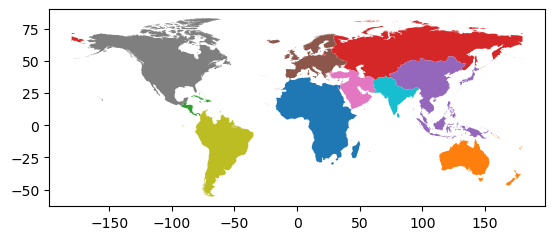

In [138]:
indicatorsByRegion=indicators.dissolve(
     by="region",
     aggfunc={
         "COUNTRY": "count",
         "fragility": ["mean"],
         "co2": ["mean"],
         "ForestRev_gdp": ["mean"]
     },as_index=False,
 )


indicatorsByRegion.plot(column = 'region')

Without renaming, you can request a choropleth:

<Axes: >

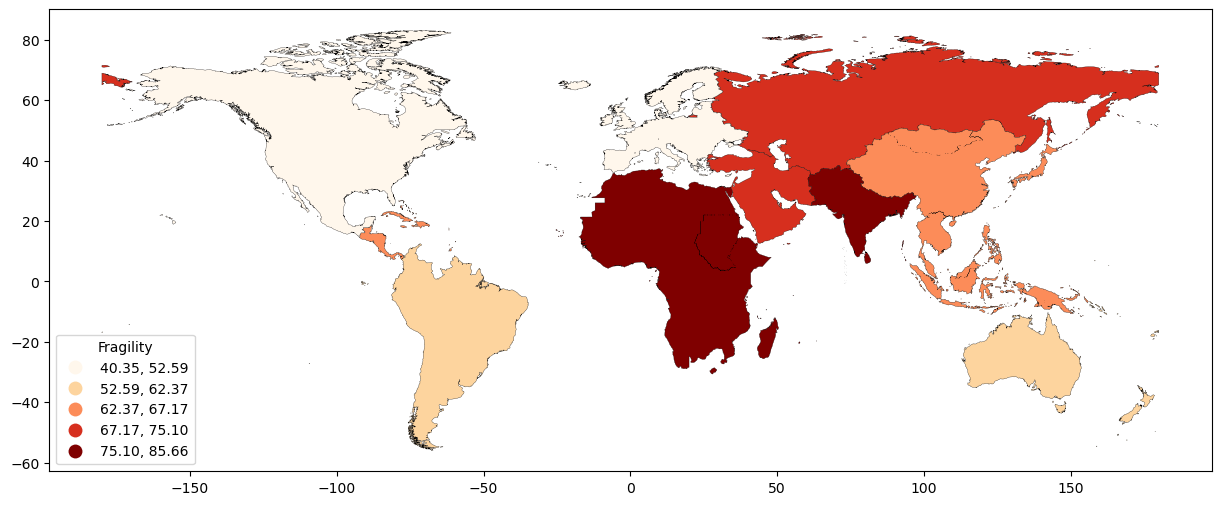

In [159]:
indicatorsByRegion.plot(column =('fragility', 'mean'),scheme='quantiles', cmap='OrRd',
                        legend=True,
                        legend_kwds={"title": "Fragility",'loc': 'lower left'},
                        edgecolor='black',linewidth=0.2,
                        figsize=(15, 10))

<a class="anchor" id="31"></a>

## Creating the convex hull

Some time you may have the need to create a polygon that serves as an envelope to a set of points.

For this example, let me compute the centroid coordinates:

In [167]:
brazil_5641.centroid

29    POINT (3884486.179 8756856.093)
dtype: geometry

In [172]:
# then
brazil_5641.centroid.x.values[0],brazil_5641.centroid.y.values[0]

(3884486.1789775593, 8756856.09281343)

In [175]:
airports_5641

,name,kind,latitude_deg,longitude_deg,elevation_ft,region_name,municipality,geometry
0,Guarulhos - Governador André Franco Montoro In...,large_airport,-23.431944,-46.467778,2461.0,São Paulo,São Paulo,POINT (4614202.306 7334259.930)
1,Rio Galeão – Tom Jobim International Airport,large_airport,-22.809999,-43.250557,28.0,Rio de Janeiro,Rio De Janeiro,POINT (4972125.000 7409069.810)
2,Congonhas Airport,medium_airport,-23.627657,-46.654601,2631.0,São Paulo,São Paulo,POINT (4593417.849 7310645.617)
3,Santos Dumont Airport,medium_airport,-22.910500,-43.163101,11.0,Rio de Janeiro,Rio de Janeiro,POINT (4981854.666 7397004.833)
4,Presidente Juscelino Kubitschek International ...,large_airport,-15.869167,-47.920834,3497.0,Distrito Federal,Brasília,POINT (4452546.729 8223176.558)
...,...,...,...,...,...,...,...,...
6666,Fazenda Alegria - H Heliport,heliport,-4.334444,-45.359167,135.0,Maranhão,Vitorino Freire,POINT (4737537.643 9520548.356)
6667,Volta Redonda Airport,closed,-22.497800,-44.085000,1245.0,Rio de Janeiro,Volta Redonda,POINT (4879291.437 7446491.610)
6668,Unimed Volta Redonda Helipad,heliport,-22.533988,-44.076918,1385.0,Rio de Janeiro,Volta Redonda,POINT (4880190.577 7442158.328)
6669,Santa Helena Heliport,heliport,-23.598510,-47.441196,2254.0,São Paulo,Votorantim,POINT (4505907.479 7314164.686)


In [176]:
# coordinates
centroidX,centroidY=brazil_5641.centroid.x.values[0],brazil_5641.centroid.y.values[0]

# subsets of medium airports
Brazil_AirTopLeft=airports_5641[airports_5641.kind=='medium_airport'].cx[:centroidX,centroidY:]
Brazil_AirTopRight=airports_5641[airports_5641.kind=='medium_airport'].cx[centroidX:,centroidY:]
Brazil_AirBottomLeft=airports_5641[airports_5641.kind=='medium_airport'].cx[:centroidX,:centroidY]
Brazil_AirBottomRight=airports_5641[airports_5641.kind=='medium_airport'].cx[centroidX:,:centroidY]

Let me plot the subsets:

<Axes: >

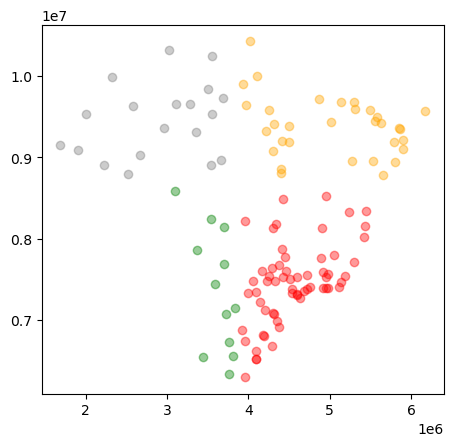

In [177]:
base=Brazil_AirTopLeft.plot(facecolor='grey', alpha=0.4)
Brazil_AirTopRight.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_AirBottomLeft.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_AirBottomRight.plot(ax=base,facecolor='red', alpha=0.4)

Notice we have simple points in each subset:

In [178]:
Brazil_AirBottomLeft

,name,kind,latitude_deg,longitude_deg,elevation_ft,region_name,municipality,geometry
8,Cataratas International Airport,medium_airport,-25.594167,-54.489444,786.0,Paraná,Foz do Iguaçu,POINT (3721774.865 7071323.040)
15,Campo Grande Airport,medium_airport,-20.469998,-54.673988,1833.0,Mato Grosso do Sul,Campo Grande,POINT (3701243.952 7687543.733)
20,Marechal Rondon Airport,medium_airport,-15.652900,-56.116699,617.0,Mato Grosso,Cuiabá,POINT (3540739.278 8248021.581)
50,Coronel Adalberto Mendes da Silva Airport,medium_airport,-25.000323,-53.501208,2481.0,Paraná,Cascavel,POINT (3831718.226 7143997.144)
75,Ponta Porã Airport,medium_airport,-22.549601,-55.702599,2156.0,Mato Grosso do Sul,Ponta Porã,POINT (3586808.785 7440288.417)
77,Santo Ângelo Airport,medium_airport,-28.282503,-54.169623,1056.0,Rio Grande do Sul,Santo Ângelo,POINT (3757355.633 6737578.539)
85,Maestro Marinho Franco Airport,medium_airport,-16.584292,-54.724803,1467.0,Mato Grosso,Rondonópolis,POINT (3695590.675 8140827.535)
86,Brigadeiro Camarão Airport,medium_airport,-12.694400,-60.098301,2018.0,Rondônia,Vilhena,POINT (3097777.568 8585400.848)
105,Santa Maria Airport,medium_airport,-29.711399,-53.688202,287.0,Rio Grande do Sul,Santa Maria,POINT (3810914.745 6556752.132)
141,Corumbá International Airport,medium_airport,-19.011930,-57.672772,463.0,Mato Grosso do Sul,Corumbá,POINT (3367622.840 7858868.554)


In this situation, you can not make a _convex hull_:

<Axes: >

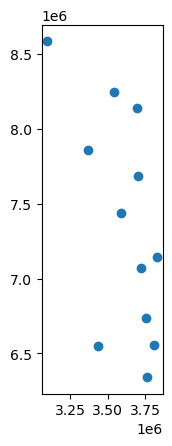

In [179]:
Brazil_AirBottomLeft.convex_hull.plot()

You first need to dissolve, and then you create a hull, an envelope of  convex angles:

<Axes: >

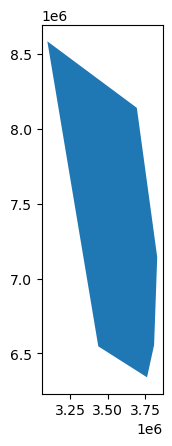

In [180]:
Brazil_AirBottomLeft.dissolve().convex_hull.plot()

As we saw, the convex hull is a polygon: 

In [181]:
Brazil_AirBottomLeft.dissolve().convex_hull

0    POLYGON ((3763743.842 6340901.399, 3438220.327...
dtype: geometry

We can make hulls from any spatial object:

<Axes: >

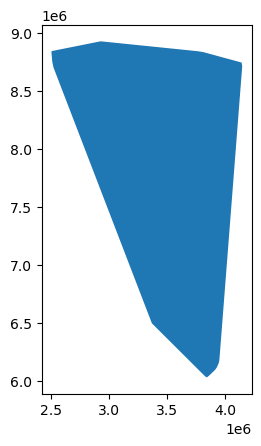

In [182]:
# SW of Brazil as convex hull
Brazil_bottomLeft.convex_hull.plot()

In this last case, what if we the polygons had not been previously combined?

<Axes: >

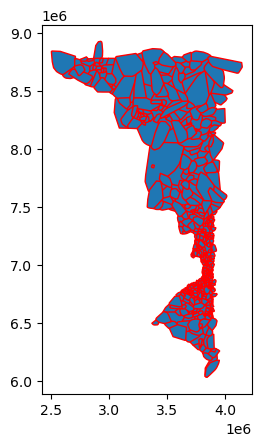

In [183]:
brazil_municipalities.cx[:centroidX,:centroidY].convex_hull.plot(edgecolor='red')

That is, you get a convex hull for each geometry. 

We can also use _union_ before creating a convex hull:

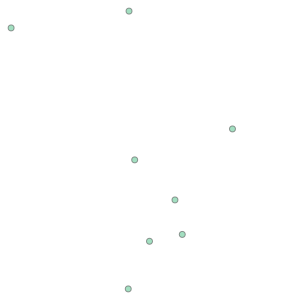

In [185]:
# just the union
large_airport=airports_5641[airports_5641.kind=='large_airport']
large_airport.unary_union

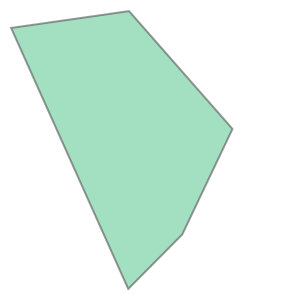

In [186]:
# hull of the union
large_airport.unary_union.convex_hull

Let's turn the GS into a GDF:

In [187]:
LargeAirport_hull= gpd.GeoDataFrame(index=[0],
                                    crs=large_airport.crs,
                                    geometry=[large_airport.unary_union.convex_hull])
LargeAirport_hull['name']='large airports hull' # optional

# then

LargeAirport_hull

,geometry,name
0,"POLYGON ((4382272.317 6814299.684, 3103184.311...",large airports hull


Let's use the GDF in plotting:

<Axes: >

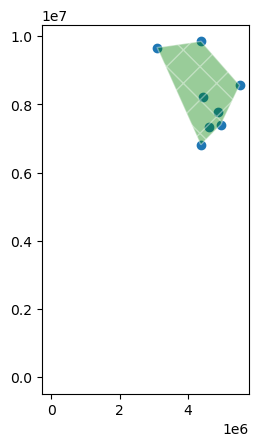

In [188]:
base=brazil.plot(facecolor='yellow')
large_airport.plot(ax=base)
LargeAirport_hull.plot(ax=base,facecolor='green',
                       edgecolor='white',alpha=0.4,
                       hatch='X')

### Exercise 7 

<div class="alert-success">

1. Select some points from your maps.
    
2. Create the convex hull for those points.
    
3. Turn the hull into a GDF.
    
4. Plot the hull on top of the country.
    
</div>

## Spatial Overlay

We might need to create or find some geometries from the geometries we already have. Using a set theory approach, we will se the use of _intersection_, _union_, _difference_, and _symmetric difference_.

Let me create this GeoDFs:

In [189]:
# the north
MunisN_brazil=brazil_municipalities.cx[:,centroidY:]
# the south
MunisS_brazil=brazil_municipalities.cx[:,:centroidY]
# the west
MunisW_brazil=brazil_municipalities.cx[:centroidX,:]
# the east
MunisE_brazil=brazil_municipalities.cx[centroidX:,:]

Let me plot:

<Axes: >

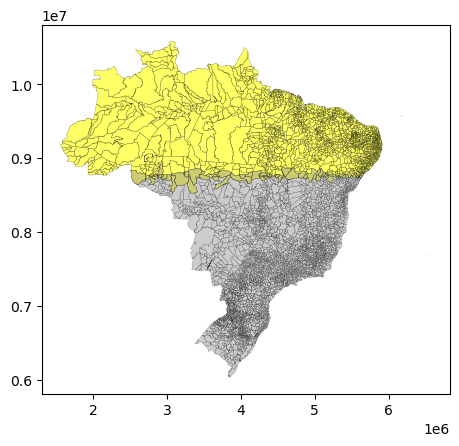

In [210]:
base=MunisN_brazil.plot(facecolor='yellow', edgecolor='black',linewidth=0.2, alpha=0.6)
MunisS_brazil.plot(facecolor='grey', edgecolor='black',linewidth=0.2,ax=base, alpha=0.4)

<Axes: >

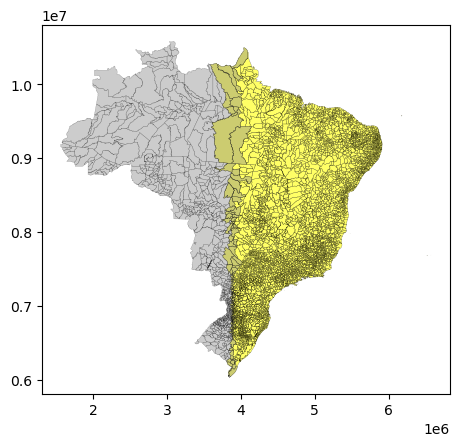

In [211]:
base=MunisE_brazil.plot(facecolor='yellow', edgecolor='black',linewidth=0.2, alpha=0.6)
MunisW_brazil.plot(facecolor='grey', edgecolor='black',linewidth=0.2,ax=base, alpha=0.4)

### Intersection

We keep what is common in both GeoDFs:

/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


<Axes: >

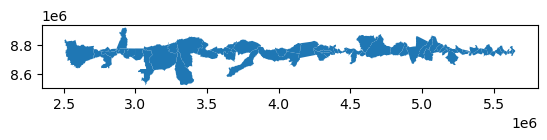

In [223]:
munisNS_brazil=MunisN_brazil.overlay(MunisS_brazil, how="intersection",keep_geom_type=True)
munisNS_brazil.plot()

This is similar to a _spatial join_:

<Axes: >

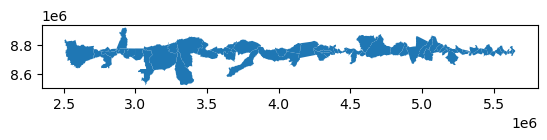

In [213]:
MunisN_brazil.sjoin(MunisS_brazil, how="inner", predicate='contains').plot()

/Users/JoseManuel/opt/anaconda3/envs/SpatialDS_311_pandas2/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union


<Axes: >

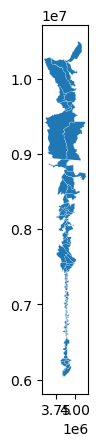

In [224]:
# keeping the overlay
munisWE_brazil=MunisW_brazil.overlay(MunisE_brazil, how="intersection",keep_geom_type=True)
munisWE_brazil.plot(edgecolor='white',linewidth=0.1)

### Union

Let me unite the previous two GeoDFs. First, take a look at each one:

In [225]:
munisNS_brazil.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ADM0_EN_1     65 non-null     object  
 1   ADM0_PT_1     65 non-null     object  
 2   ADM0_PCODE_1  65 non-null     object  
 3   ADM1_PT_1     65 non-null     object  
 4   ADM1_PCODE_1  65 non-null     object  
 5   ADM2_PT_1     65 non-null     object  
 6   ADM2_PCODE_1  65 non-null     object  
 7   ET_ID_1       65 non-null     int64   
 8   ADM0_EN_2     65 non-null     object  
 9   ADM0_PT_2     65 non-null     object  
 10  ADM0_PCODE_2  65 non-null     object  
 11  ADM1_PT_2     65 non-null     object  
 12  ADM1_PCODE_2  65 non-null     object  
 13  ADM2_PT_2     65 non-null     object  
 14  ADM2_PCODE_2  65 non-null     object  
 15  ET_ID_2       65 non-null     int64   
 16  geometry      65 non-null     geometry
dtypes: geometry(1), int64(2), object(14)
memory usag

In [226]:
munisWE_brazil.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ADM0_EN_1     115 non-null    object  
 1   ADM0_PT_1     115 non-null    object  
 2   ADM0_PCODE_1  115 non-null    object  
 3   ADM1_PT_1     115 non-null    object  
 4   ADM1_PCODE_1  115 non-null    object  
 5   ADM2_PT_1     115 non-null    object  
 6   ADM2_PCODE_1  115 non-null    object  
 7   ET_ID_1       115 non-null    int64   
 8   ADM0_EN_2     115 non-null    object  
 9   ADM0_PT_2     115 non-null    object  
 10  ADM0_PCODE_2  115 non-null    object  
 11  ADM1_PT_2     115 non-null    object  
 12  ADM1_PCODE_2  115 non-null    object  
 13  ADM2_PT_2     115 non-null    object  
 14  ADM2_PCODE_2  115 non-null    object  
 15  ET_ID_2       115 non-null    int64   
 16  geometry      115 non-null    geometry
dtypes: geometry(1), int64(2), object(14)
memory us

The overlay combines the geometries, but not the attributes. Let me subset and show you:

In [227]:
keep=['ADM0_EN_1','ADM1_PT_1','ADM2_PT_1','geometry']
munisNS_brazil=munisNS_brazil.loc[:,keep]
munisWE_brazil=munisWE_brazil.loc[:,keep]


In [228]:
# now 
munisNS_brazil.overlay(munisWE_brazil,how="union",keep_geom_type=True)

,ADM0_EN_1_1,ADM1_PT_1_1,ADM2_PT_1_1,ADM0_EN_1_2,ADM1_PT_1_2,ADM2_PT_1_2,geometry
0,Brazil,Mato Grosso,São Félix do Araguaia,Brazil,Mato Grosso,São Félix do Araguaia,"POLYGON ((3974842.572 8772389.594, 3975012.329..."
1,Brazil,Rondônia,Cacoal,NaN,NaN,NaN,"POLYGON ((2997393.730 8770664.256, 2997393.730..."
2,Brazil,Rondônia,Espigão D'Oeste,NaN,NaN,NaN,"POLYGON ((3056978.535 8777571.933, 3056645.811..."
3,Brazil,Rondônia,Guajará-Mirim,NaN,NaN,NaN,"MULTIPOLYGON (((2708331.032 8726681.673, 27079..."
4,Brazil,Rondônia,Ji-Paraná,NaN,NaN,NaN,"POLYGON ((2933571.782 8920496.537, 2933789.072..."
...,...,...,...,...,...,...,...
174,NaN,NaN,NaN,Brazil,Mato Grosso,São José do Xingu,"POLYGON ((3981564.960 8856938.657, 3981517.428..."
175,NaN,NaN,NaN,Brazil,Mato Grosso,Tesouro,"POLYGON ((3872193.739 8238559.612, 3872628.318..."
176,NaN,NaN,NaN,Brazil,Mato Grosso,Torixoréu,"POLYGON ((3945997.415 8193554.551, 3945583.207..."
177,NaN,NaN,NaN,Brazil,Goiás,Mineiros,"MULTIPOLYGON (((3905703.826 8114180.861, 39060..."


As you see, geometries are fine, but not attributes. It is strictly NOT appending the GeoDFs:

In [229]:
# appending
pd.concat([munisNS_brazil,munisWE_brazil],ignore_index=True)

,ADM0_EN_1,ADM1_PT_1,ADM2_PT_1,geometry
0,Brazil,Rondônia,Cacoal,"POLYGON ((2997393.730 8770664.256, 2997393.730..."
1,Brazil,Rondônia,Espigão D'Oeste,"POLYGON ((3056978.535 8777571.933, 3056645.811..."
2,Brazil,Rondônia,Guajará-Mirim,"MULTIPOLYGON (((2708331.032 8726681.673, 27079..."
3,Brazil,Rondônia,Ji-Paraná,"POLYGON ((2933571.782 8920496.537, 2933789.072..."
4,Brazil,Rondônia,Presidente Médici,"POLYGON ((2914558.967 8738429.583, 2915047.868..."
...,...,...,...,...
175,Brazil,Mato Grosso,São Félix do Araguaia,"POLYGON ((3974197.494 8772623.298, 3974842.572..."
176,Brazil,Mato Grosso,Tesouro,"POLYGON ((3872193.739 8238559.612, 3872628.318..."
177,Brazil,Mato Grosso,Torixoréu,"POLYGON ((3945997.415 8193554.551, 3945583.207..."
178,Brazil,Goiás,Mineiros,"MULTIPOLYGON (((3905703.826 8114180.861, 39060..."


You will append if you are interested in the keeping the attributes. But you just do the overlay if you are planing to combine final results:

<Axes: >

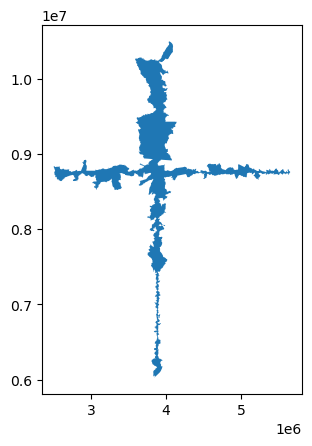

In [230]:
munisNS_brazil.dissolve().overlay(munisWE_brazil.dissolve(), how="union",keep_geom_type=True).dissolve().plot()

Let me create an object to save the previous result:

In [231]:
muniMidBrazil=munisNS_brazil.dissolve().overlay(munisWE_brazil.dissolve(), how="union",keep_geom_type=True).dissolve()
muniMidBrazil

,geometry,ADM0_EN_1_1,ADM1_PT_1_1,ADM2_PT_1_1,ADM0_EN_1_2,ADM1_PT_1_2,ADM2_PT_1_2
0,"MULTIPOLYGON (((3873395.621 6740520.149, 38739...",Brazil,Rondônia,Cacoal,Brazil,Pará,Almeirim


In [232]:
# some cleaning

muniMidBrazil['zone']='middles'
muniMidBrazil=muniMidBrazil.loc[:,['ADM0_EN_1_1','zone','geometry']]   
muniMidBrazil

,ADM0_EN_1_1,zone,geometry
0,Brazil,middles,"MULTIPOLYGON (((3873395.621 6740520.149, 38739..."


### Difference

Here, you keep what belongs to the GeoDF to left that is not in the GeoDF to the right:

<Axes: >

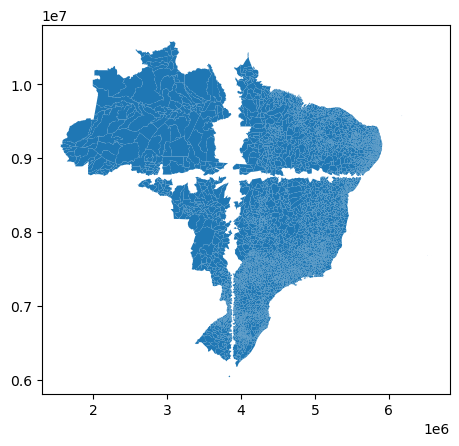

In [233]:
# with the municipalities
brazil_municipalities.overlay(muniMidBrazil, how='difference').plot()

<Axes: >

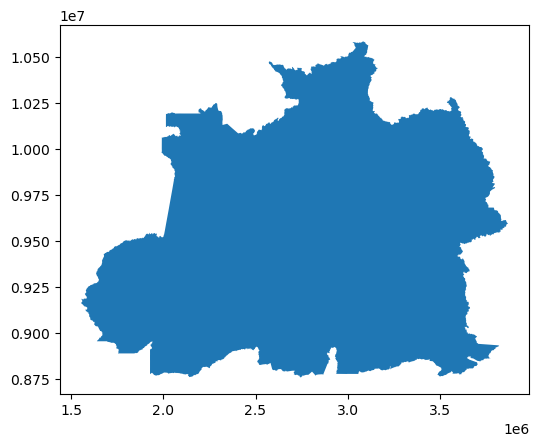

In [234]:
# with the zones
Brazil_topLeft.overlay(muniMidBrazil, how='difference').plot()

### Symmetric Difference

This is the opposite to *intersection*, you keep what is not in the intersection:

<Axes: >

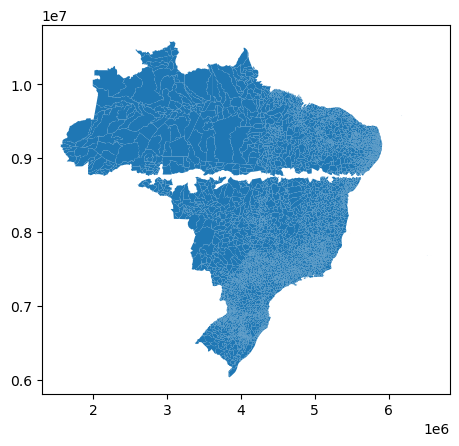

In [235]:
MunisN_brazil.overlay(MunisS_brazil, how="symmetric_difference",keep_geom_type=False).plot()

<Axes: >

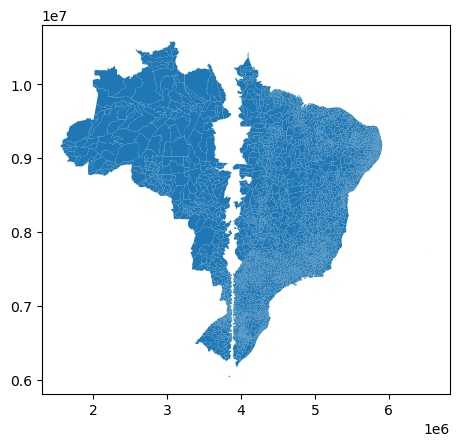

In [236]:
MunisW_brazil.overlay(MunisE_brazil, how="symmetric_difference",keep_geom_type=False).plot()

### Exercise 6 

<div class="alert-success">

1. Apply two of these operations to your maps.
2. Apply two of these operations to the  next maps:
        
</div>

In [ ]:
# hulls for the mid size airports:
Brazil_AirTopLeft_hull=Brazil_AirTopLeft.dissolve().convex_hull
Brazil_AirTopRight_hull=Brazil_AirTopRight.dissolve().convex_hull
Brazil_AirBottomLeft_hull=Brazil_AirBottomLeft.dissolve().convex_hull
Brazil_AirBottomRight_hull=Brazil_AirBottomRight.dissolve().convex_hull

In [ ]:
base = brazil.plot(color='white', edgecolor='black') #unprojected
muniMidBrazil.plot(ax=base,facecolor='magenta',alpha=0.4) #unprojected
LargeAirport_hull.plot(ax=base,facecolor='purple',alpha=0.4)
Brazil_AirTopLeft_hull.plot(ax=base,facecolor='grey', alpha=0.4)
Brazil_AirTopRight_hull.plot(ax=base,facecolor='orange', alpha=0.4)
Brazil_AirBottomLeft_hull.plot(ax=base,facecolor='green', alpha=0.4)
Brazil_AirBottomRight_hull.plot(ax=base,facecolor='red', alpha=0.4)

<a class="anchor" id="4"></a>

## Validity of Geometry

Geometries are created in a way that some issues may appear, especially in (multi) polygons.
Let's check if our recent maps on states and municipalities are valid:

In [ ]:
# non valid
brazil_municipalities[~brazil_municipalities.is_valid]

In [ ]:
# see the invalid:
brazil_municipalities[~brazil_municipalities.is_valid].plot()

It is difficult to see what is wrong. Let's get some information:

In [ ]:
# what is wrong?

from shapely.validation import explain_validity, make_valid

explain_validity(brazil_municipalities[~brazil_municipalities.is_valid].geometry)

In [ ]:
# varieties?
brazil_municipalities['validity']=[x.split('[')[0] for x in brazil_municipalities.geometry.apply(lambda x: explain_validity(x))]
brazil_municipalities['validity'].value_counts()

In [ ]:
# solving the issue:
brazil_municipalities.drop(columns=['validity'],inplace=True)

brazil_municipalities_valid=brazil_municipalities.copy()

brazil_municipalities_valid['geometry'] = [make_valid(row)  if not row.is_valid else row for row in brazil_municipalities_valid['geometry'] ]
#any invalid?
brazil_municipalities_valid[~brazil_municipalities_valid.is_valid]

The _solution_ we got may help for some advanced techniques, but may also give us some extra trouble. Notice that once geopandas solved the problem, you  have created **collections**:

In [ ]:
[x for x in brazil_municipalities_valid["geometry"]]

In [ ]:
pd.Series([type(x) for x in brazil_municipalities_valid.geometry]).value_counts()

In [ ]:
# brazil.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='country', driver="GPKG")
# brazil_cities.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='cities', driver="GPKG")
# brazil_rivers.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='rivers', driver="GPKG")
# airports.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"),layer='airports', driver="GPKG")
# brazil_border.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='border', driver="GPKG")
# brazil_states.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='states', driver="GPKG")
# brazil_municipalities.to_file(os.path.join("maps","brazilMaps_5641_all.gpkg"), layer='municipalities', driver="GPKG")